In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend
import numpy as np
import matplotlib.pyplot as plt 
import h5py

In [50]:
#"phenomene","pitch","tension","breathiness","voicing","gender","toneshift"
N=10500
data_path='C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\dataset\\'
data_x=np.zeros(shape=(N,128,128,1),dtype=(np.float))
for i in range(N):
    if (i/N*100)%5==0:
        print('%d'%(i/N*100)+'%')
    t=h5py.File(data_path+'%05d.mat'%(i+1))
    t=t['MEL'][:]
    t=np.log(t)+40
    data_x[i,:,:,0]=t
print(np.shape(data_x))

f=open(data_path+'params.txt')
range_param=[[-1,1],[-1,1],[0.2,1],[-0.1,0.1],[-400,400]]
data_y=[];
for line in f:
    data_y.append(line.split())
    data_y[-1]=data_y[-1][2:]
    for i in range(5):
        data_y[-1][i]=(float(data_y[-1][i])-range_param[i][0])/(range_param[i][1]-range_param[i][0])
data_y=np.array(data_y)
print(np.shape(data_y))
print(data_y[0])

0%
5%
10%
15%
20%
25%
30%
35%
40%
45%
50%
60%
65%
70%
75%
80%
85%
90%
95%
(10500, 128, 128, 1)
(10500, 5)
[0.26595201 0.13623012 0.92718824 0.63776558 0.52257525]


34.82796300008124
3.038908706321102


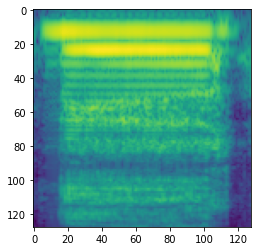

In [51]:
plt.imshow(np.transpose(data_x[10,:,:,0]))
print(np.max(data_x[:,:,:,0]))
print(np.min(data_x[:,:,:,0]))

In [60]:
def Conv_BN_Relu(filters, kernel_size, strides, input_layer):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


# ResNet18网络对应的残差模块a和残差模块b
def residual_a_or_b(input_x, filters, flag):
    if flag == 'a':
        # 主路
        x = Conv_BN_Relu(filters, (3, 3), 1, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        # 输出
        y = Add()([x, input_x])

        return y
    elif flag == 'b':
        # 主路
        x = Conv_BN_Relu(filters, (3, 3), 2, input_x)
        x = Conv_BN_Relu(filters, (3, 3), 1, x)

        # 支路下采样
        input_x = Conv_BN_Relu(filters, (1, 1), 2, input_x)

        # 输出
        y = Add()([x, input_x])

        return y
    # 其实还有更简单的封装方式，是python编程的知识了，我就不再多阐述了，主要是让同学们理解流程


# 第一层
input_layer = Input((128, 128, 1))
conv1 = Conv_BN_Relu(64, (7, 7), 1, input_layer)
conv1_Maxpooling = MaxPooling2D((3, 3), strides=2, padding='same')(conv1)

# conv2_x
x = residual_a_or_b(conv1_Maxpooling, 64, 'b')
x = residual_a_or_b(x, 64, 'a')

# conv3_x
x = residual_a_or_b(x, 128, 'b')
x = residual_a_or_b(x, 128, 'a')

# conv4_x
x = residual_a_or_b(x, 256, 'b')
x = residual_a_or_b(x, 256, 'a')

# conv5_x
x = residual_a_or_b(x, 512, 'b')
x = residual_a_or_b(x, 512, 'a')

# 最后一层
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1000)(x)
x = Dropout(0.5)(x)
y = Dense(5)(x)
model = Model([input_layer], [y])

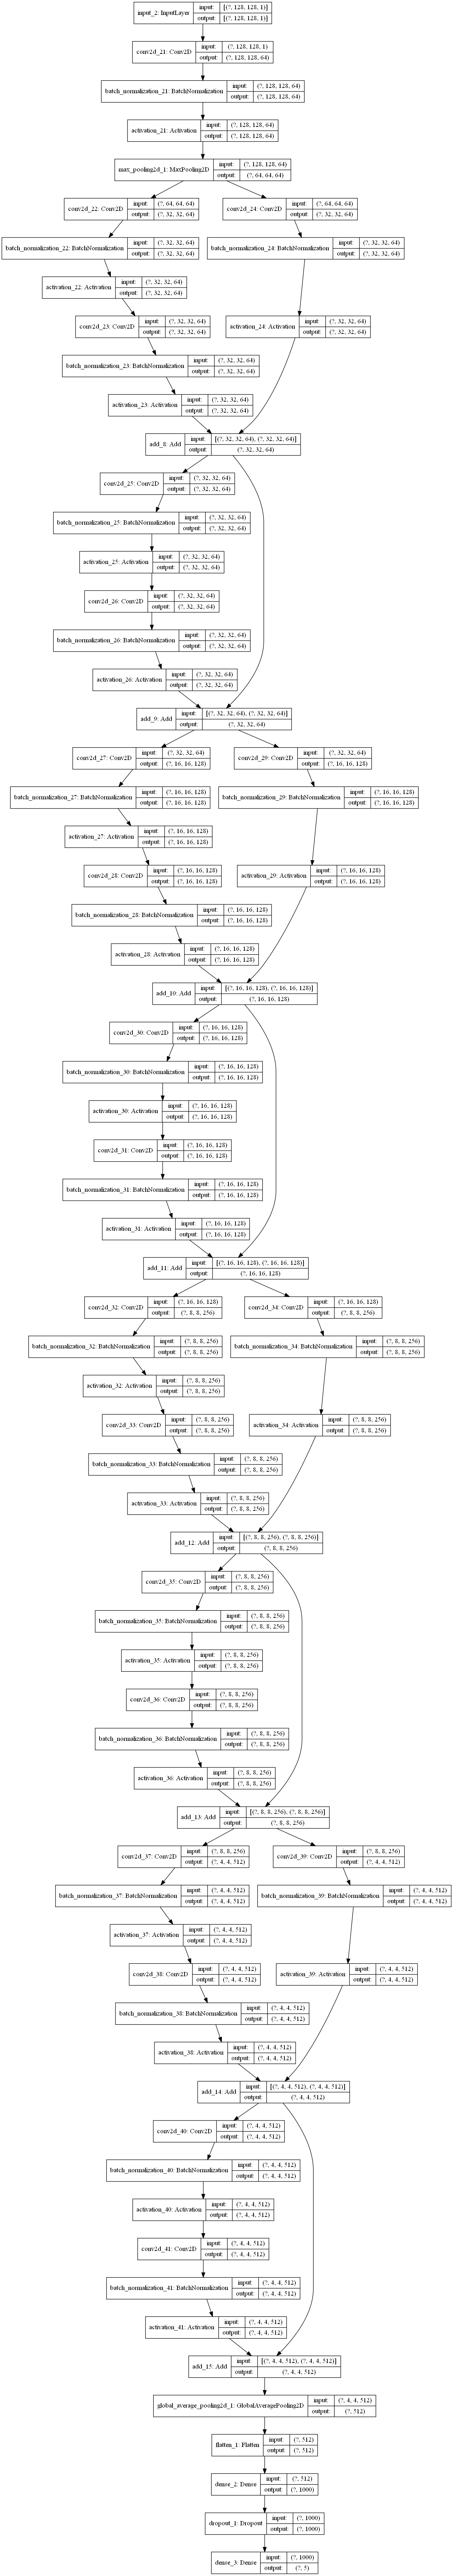

In [7]:
#model.summary()
plot_model(model,show_shapes=True,expand_nested=True)

In [73]:
#index=10
print(np.shape(np.expand_dims(data_x[index,:,:,:],0)))
print(np.shape(np.expand_dims(data_y[index,:],0)))
model.compile(loss='mean_squared_error',optimizer='Adam')
history=model.fit(data_x,data_y,epochs=600,verbose=1,validation_split=0.3,use_multiprocessing=True)

(1, 128, 128, 1)
(1, 5)
Train on 7349 samples, validate on 3151 samples
Epoch 1/600
7349/7349 [==============================] - 24s 3ms/sample - loss: 0.0805 - val_loss: 0.4017
Epoch 2/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0662 - val_loss: 0.1183
Epoch 3/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0548 - val_loss: 0.1174
Epoch 4/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0381 - val_loss: 0.0846
Epoch 5/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0309 - val_loss: 0.1666
Epoch 6/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0266 - val_loss: 0.0846
Epoch 7/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0234 - val_loss: 0.0613
Epoch 8/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 0.0210 - val_loss: 0.0897
Epoch 9/600
7349/7349 [==============================] - 19s 3ms/sample - loss: 

Text(0, 0.5, 'MSE')

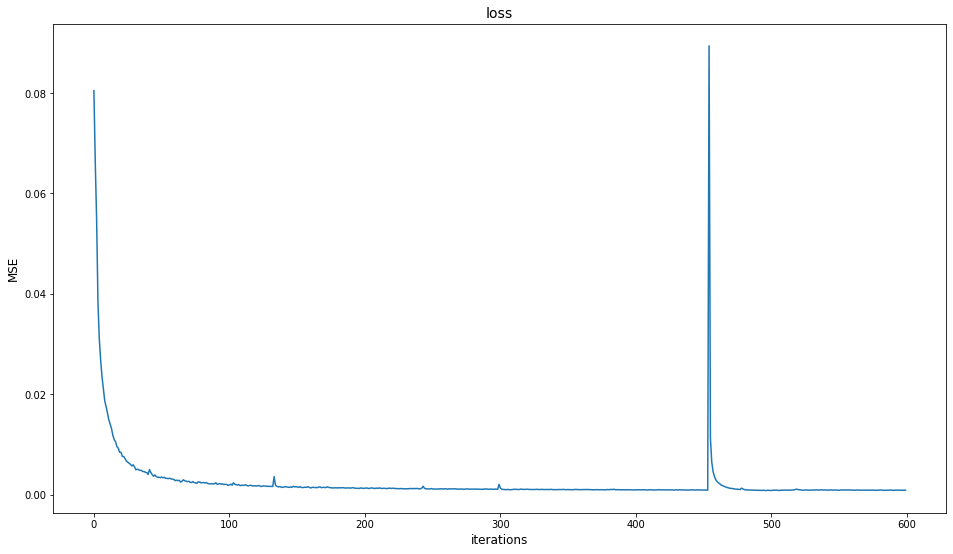

In [74]:
t=history.history['loss']
plt.figure(figsize=(16,9))
plt.plot([i for i in range(np.shape(t)[0])],t)
plt.title('loss',fontsize=14)
plt.xlabel('iterations',fontsize=12)
plt.ylabel('MSE',fontsize=12)
#plt.xlim([0,100])

In [77]:
index=105
print(np.shape(np.expand_dims(data_x[index],0)))
t=backend.function([model.input],[model.output])(np.expand_dims(data_x[index],0))
t_pred=np.squeeze(t).tolist()
t_true=np.squeeze(data_y[index]).tolist()
#t_input=np.squeeze(x_input).tolist()
print(t_pred)
print(t_true)

(1, 128, 128, 1)
[0.6525493860244751, 0.15184035897254944, 0.5274468660354614, 0.955424427986145, 0.44083794951438904]
[0.6299813524096805, 0.1620340763215884, 0.5243274149523671, 0.9753122172683544, 0.4343723923772571]


In [78]:
model.save("C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\my_model2.h5")

In [79]:
import pickle
 
with open('C:\\Users\\Lenovo\\Desktop\\autocover_test\\resnet\\models\\trainHistory2.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    
#with open('trainHistoryDict.txt','rb') as file_pi:
#    history=pickle.load(file_pi)